Using random forest regressor instead of the linear regressor in ML3.3.8

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 
    ice = DS_w.CO2ICE.values

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append(((p[:,i-1,:,:] - p[:,i,:,:])*np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla.append(ice.reshape(-1)) 
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla_summer, uif_summer = in_out('af_summer', 'wf_summer')  #first snapshot of data (0002-00172), summer

In [4]:
sla_fall, uif_fall = in_out('af_fall', 'wf_fall') #(0002-00352), fall

In [5]:
sla_winter, uif_winter = in_out('af_winter', 'wf_winter') #(0002-00352), winter 

In [6]:
sla_spring, uif_spring = in_out('af_spring', 'wf_spring') #(0002-00652), spring 

In [7]:
sla_test_set, uif_test_set = in_out("af_test", "wf_test") #(0002-00472), testing on this as well to check if overfit

In [8]:
uif_train = np.concatenate((uif_summer, uif_fall, uif_winter, uif_spring), axis=0) #total uif for training

In [9]:
sla_train = np.concatenate((sla_summer, sla_fall, sla_winter, sla_spring), axis=0) #total sla for training

In [10]:
uif_train = uif_train[::100]
sla_train = sla_train[::100] #use every 100th element from original training data

In [11]:
sla_train.shape

(22706, 106)

In [12]:
#from sklearn.model_selection import train_test_split
#sla_train, sla_test, uif_train, uif_test = train_test_split(sla_train, uif_train, test_size=0.99, random_state=42)

In [13]:
sla_summer.shape

(619488, 106)

# Predicting Summer:

In [14]:
from sklearn.ensemble import RandomForestRegressor
rfr1 = RandomForestRegressor()
rfr1.fit(sla_train,uif_train)
uif_lin = rfr1.predict(sla_summer)  
uif_out = uif_summer

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

2.8034515628142804

In [16]:
np.min(uif_out)

17.541994

In [17]:
np.max(uif_out)

339.41235

In [18]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

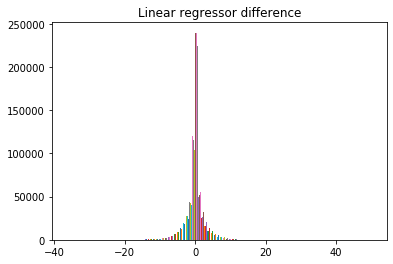

In [19]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [20]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [21]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

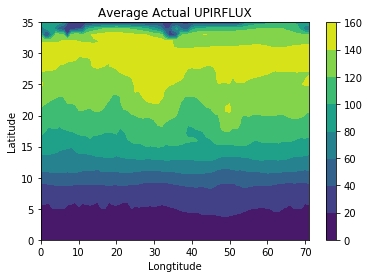

In [22]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

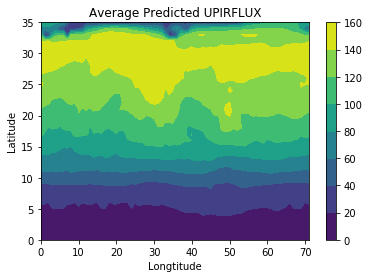

In [23]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

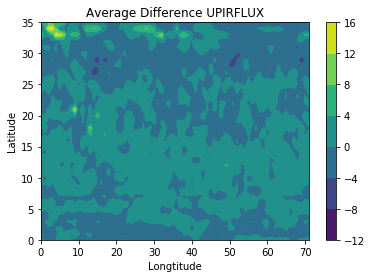

In [24]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

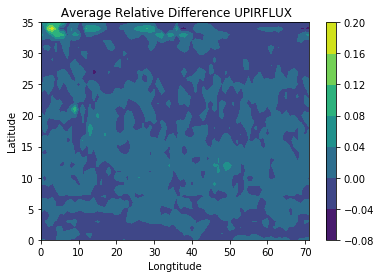

In [25]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [26]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

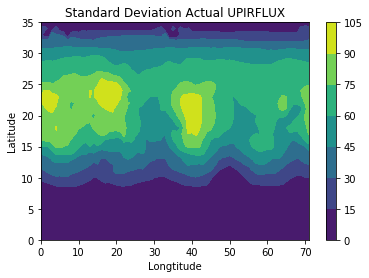

In [27]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

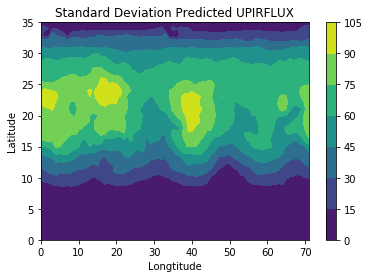

In [28]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

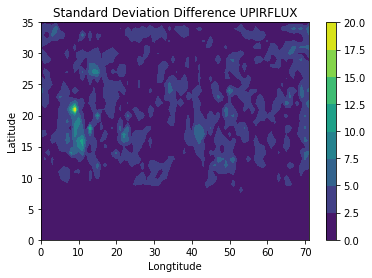

In [29]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [30]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [31]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [32]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.25540387,  0.0179383 ,  0.10729669, ..., -0.13520942,
         0.15702527, -0.00582241],
       [ 0.25539843,  0.01793718,  0.10728618, ..., -0.13522094,
         0.157022  , -0.00581964],
       [ 0.25539492,  0.0179366 ,  0.10727847, ..., -0.13522911,
         0.15701982, -0.00581722],
       ...,
       [ 0.86035515,  0.41742686,  0.51741145, ...,  0.29067748,
         0.67596401,  0.28927046],
       [ 0.85448812,  0.40621339,  0.50733385, ...,  0.28775361,
         0.66870176,  0.27811102],
       [ 0.83894769,  0.38944098,  0.48855793, ...,  0.27573638,
         0.65133276,  0.26189227]])

In [33]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.25540387, 0.25539843, 0.25539492, 0.25537806, 0.25532183,
       0.25523142, 0.25504104, 0.25465465, 0.25428617, 0.25416057,
       0.25422207, 0.25424964, 0.25404927, 0.25360262, 0.25300417,
       0.25231447, 0.25120494, 0.24918541, 0.24675098, 0.24469926,
       0.24376433, 0.24541993, 0.25154182, 0.26316535, 0.27921866,
       0.29971017, 0.32311473, 0.34561005, 0.3676682 , 0.3923684 ,
       0.41939541, 0.44215632, 0.4620531 , 0.48336118, 0.51606723,
       0.57620682, 0.64829028, 0.71376858, 0.76608826, 0.78621137,
       0.80601252, 0.81666298, 0.82553164, 0.83257744, 0.83892076,
       0.84379071, 0.8494186 , 0.85497316, 0.85920013, 0.86035515,
       0.85448812, 0.83894769])

In [34]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.24794463, -0.24796003, -0.24797108, -0.24808979, -0.24827917,
       -0.24834049, -0.24850571, -0.24858774, -0.24859538, -0.24882331,
       -0.24906687, -0.24919427, -0.24937333, -0.24968192, -0.25015399,
       -0.25090117, -0.25202439, -0.25348082, -0.25506307, -0.25639189,
       -0.25719106, -0.25684799, -0.25367605, -0.24623971, -0.23445192,
       -0.2190633 , -0.20256786, -0.18728719, -0.17155715, -0.15317666,
       -0.13450512, -0.11903301, -0.10569952, -0.08912513, -0.05978422,
       -0.00928839,  0.0510304 ,  0.10335503,  0.1387873 ,  0.15044792,
        0.16016532,  0.16471921,  0.16815128,  0.17024957,  0.17131291,
        0.17168815,  0.17200327,  0.16687242,  0.15932436,  0.14900749,
        0.13395785,  0.11025763])

In [35]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.13094509, 0.1309466 , 0.13094766, 0.13097316, 0.13099331,
       0.13097121, 0.13099683, 0.13087644, 0.13070222, 0.1307233 ,
       0.13089809, 0.13102615, 0.13101827, 0.13092999, 0.1308804 ,
       0.13091424, 0.1309634 , 0.13088222, 0.13068424, 0.13045724,
       0.13024481, 0.13015952, 0.1303042 , 0.13068596, 0.13107587,
       0.13144966, 0.13221122, 0.13335399, 0.13459604, 0.13596622,
       0.13779478, 0.13944084, 0.14096192, 0.14210333, 0.14286183,
       0.14500961, 0.14766077, 0.15043092, 0.15524193, 0.15862844,
       0.16290252, 0.1655206 , 0.1678771 , 0.17001379, 0.17234034,
       0.17442722, 0.17721356, 0.18067943, 0.18448388, 0.18751583,
       0.18792425, 0.18741334])

In [36]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.01730336, 0.01729742, 0.0172933 , 0.01725472, 0.01719078,
       0.0170826 , 0.01695702, 0.01677777, 0.01656366, 0.01641643,
       0.01631586, 0.01620664, 0.01601215, 0.015645  , 0.0150227 ,
       0.01409932, 0.01286728, 0.01129539, 0.00947785, 0.00749053,
       0.0056517 , 0.005225  , 0.00823488, 0.01641159, 0.02965248,
       0.04695788, 0.06547497, 0.0823955 , 0.0988569 , 0.11660315,
       0.13476415, 0.14995191, 0.16316756, 0.17888784, 0.20699185,
       0.25815724, 0.3197193 , 0.37446737, 0.41287921, 0.42518754,
       0.4360821 , 0.44183289, 0.44679146, 0.45075976, 0.45390581,
       0.45583138, 0.45761204, 0.45871081, 0.45802532, 0.45401536,
       0.44478192, 0.42719834])

In [37]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.16903374942252453


# Predicting Fall:

In [38]:
uif_lin = rfr1.predict(sla_fall) 
uif_out = uif_fall

In [39]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

3.8200274089785715

In [40]:
np.min(uif_out)

15.713927

In [41]:
np.max(uif_out)

484.24545

In [42]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

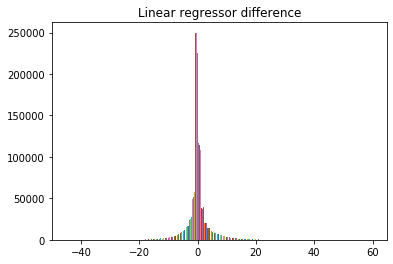

In [43]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [44]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [45]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

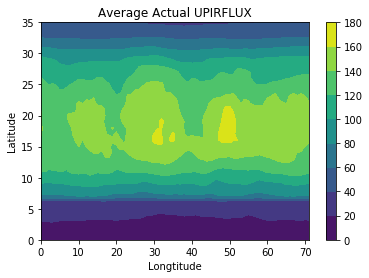

In [46]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

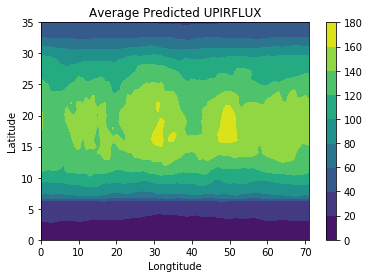

In [47]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

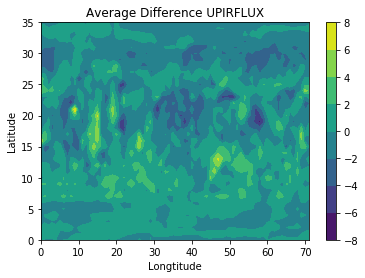

In [48]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

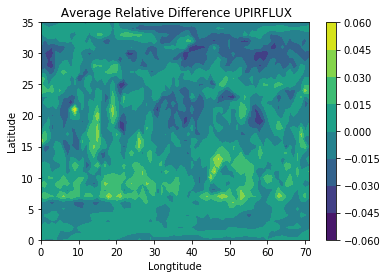

In [49]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [50]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

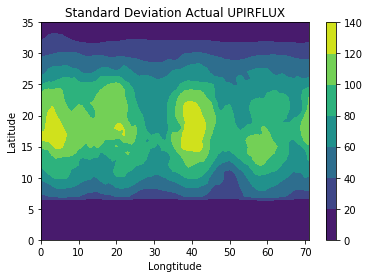

In [51]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

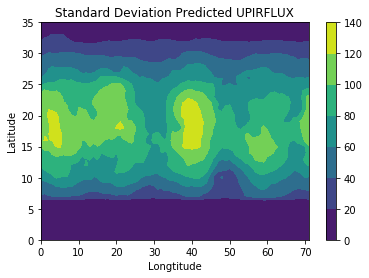

In [52]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

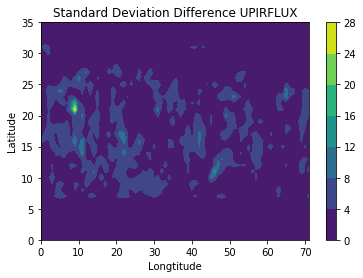

In [53]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [54]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [55]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [56]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-0.09016458, -0.33462187,  0.13411798, ..., -0.17375544,
         0.15147115, -0.24821219],
       [-0.0901619 , -0.33462031,  0.13413021, ..., -0.17375112,
         0.15147511, -0.2482011 ],
       [-0.09015986, -0.33461914,  0.13413968, ..., -0.17374845,
         0.15147815, -0.24819303],
       ...,
       [-0.35435465, -0.83847675, -0.40764346, ..., -0.5273141 ,
        -0.03082872, -0.74257936],
       [-0.36302975, -0.8390516 , -0.40351892, ..., -0.49450752,
        -0.04209368, -0.74733766],
       [-0.34780726, -0.85522992, -0.37780572, ..., -0.44787692,
        -0.03133316, -0.76851357]])

In [57]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.37738077,  0.37739196,  0.37739991,  0.37753787,  0.37771973,
        0.37770028,  0.3777821 ,  0.37798253,  0.37797456,  0.37751326,
        0.37723374,  0.37700673,  0.37677017,  0.37651979,  0.37654749,
        0.37689387,  0.37739403,  0.37803401,  0.37854432,  0.37842983,
        0.37673868,  0.37253907,  0.36522714,  0.35369013,  0.33792681,
        0.31821361,  0.29534085,  0.26705358,  0.23487263,  0.20274261,
        0.1716028 ,  0.14065486,  0.11365311,  0.09201137,  0.0746317 ,
        0.05164484,  0.01971443, -0.02363694, -0.01782463, -0.01444147,
       -0.01207622, -0.01153547, -0.01193671, -0.01386866, -0.01658074,
       -0.01841893, -0.02018211, -0.02148828, -0.02371648, -0.03082872,
       -0.04209368, -0.03133316])

In [58]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.49365595, -0.49365338, -0.49365137, -0.4937152 , -0.49374629,
       -0.49371858, -0.49365381, -0.49380369, -0.49406316, -0.49379199,
       -0.49329569, -0.49321975, -0.49376862, -0.49458884, -0.49522929,
       -0.49556459, -0.49530787, -0.49404075, -0.49188774, -0.48940636,
       -0.48784308, -0.48885068, -0.49377724, -0.50393754, -0.51906423,
       -0.53925543, -0.56248366, -0.58905963, -0.61821306, -0.64761446,
       -0.67330382, -0.69723091, -0.72079445, -0.73987472, -0.75283995,
       -0.76492782, -0.78253165, -0.81900689, -0.86178428, -0.8782774 ,
       -0.89436903, -0.90345689, -0.91444885, -0.92479475, -0.93386924,
       -0.93872976, -0.94194597, -0.94223979, -0.93897631, -0.93523248,
       -0.93962079, -0.95255615])

In [59]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.25433569, 0.25433915, 0.25434173, 0.25440851, 0.25448445,
       0.25445614, 0.25441019, 0.25447211, 0.25456215, 0.25448477,
       0.25430494, 0.25404808, 0.25399408, 0.25417995, 0.25449147,
       0.25472775, 0.25472232, 0.25444484, 0.25395875, 0.25334077,
       0.25271405, 0.25231847, 0.25221278, 0.25219427, 0.25224038,
       0.25266186, 0.25338559, 0.2536314 , 0.25345926, 0.25335181,
       0.25284077, 0.252316  , 0.25300758, 0.25394808, 0.2549902 ,
       0.25574258, 0.2540279 , 0.25280208, 0.25617798, 0.25933539,
       0.2634542 , 0.26632304, 0.26943943, 0.2725967 , 0.27575121,
       0.27763623, 0.27897622, 0.27895779, 0.27620879, 0.27030868,
       0.26512005, 0.27096513])

In [60]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.11772984, -0.11772466, -0.11772078, -0.11769526, -0.11766296,
       -0.11774261, -0.11771065, -0.11758102, -0.11743185, -0.1172916 ,
       -0.11731348, -0.11762466, -0.11794866, -0.11824611, -0.11855102,
       -0.11871037, -0.11835737, -0.11730222, -0.11585792, -0.11454145,
       -0.11445806, -0.11687836, -0.12274348, -0.13310288, -0.14805834,
       -0.16783263, -0.19117079, -0.21881982, -0.24945949, -0.27967069,
       -0.30656849, -0.33100195, -0.35270928, -0.37225796, -0.39181842,
       -0.41402887, -0.4333932 , -0.4564619 , -0.4816702 , -0.49099327,
       -0.50019878, -0.50590694, -0.51175142, -0.51767955, -0.52351115,
       -0.52713796, -0.53021492, -0.53191338, -0.53108551, -0.52724128,
       -0.51972879, -0.50196125])

In [61]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.2760033360092445


# Predicting Winter:

In [62]:
uif_lin = rfr1.predict(sla_winter)  
uif_out = uif_winter

In [63]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.268374947511339

In [64]:
np.min(uif_out)

15.832658

In [65]:
np.max(uif_out)

485.98044

In [66]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

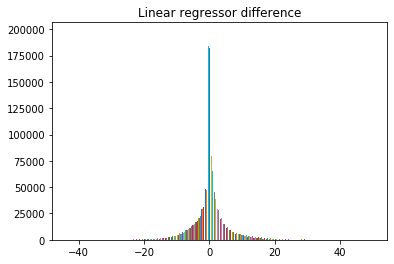

In [67]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [68]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [69]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

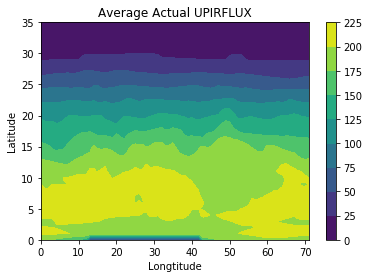

In [70]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

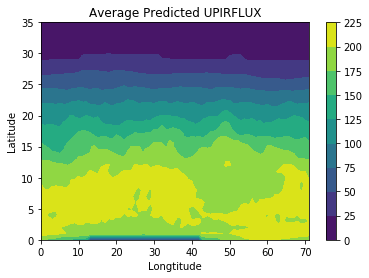

In [71]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

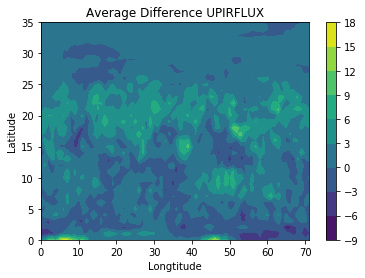

In [72]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

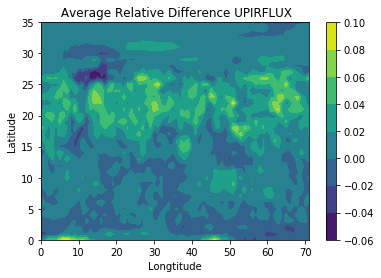

In [73]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [74]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

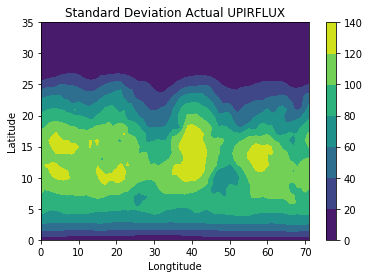

In [75]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

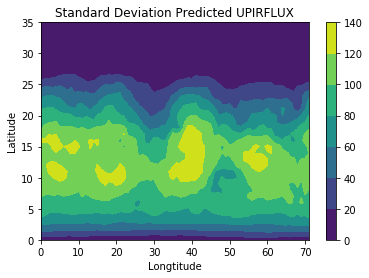

In [76]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

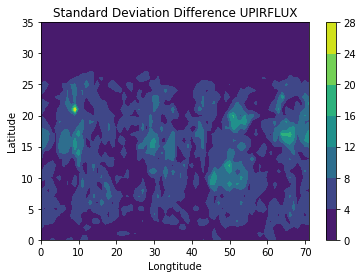

In [77]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [78]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [79]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [80]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[1.63450394, 2.13051712, 1.83481079, ..., 0.90572353, 0.76992389,
        1.1749581 ],
       [1.63447579, 2.13049236, 1.83477184, ..., 0.90571129, 0.76990494,
        1.17491983],
       [1.63445603, 2.13047387, 1.8347439 , ..., 0.90570195, 0.76989041,
        1.17489077],
       ...,
       [2.72070744, 2.79979868, 2.46483243, ..., 1.57179451, 1.46691298,
        1.47301802],
       [2.68061261, 2.76510919, 2.43202616, ..., 1.57260075, 1.45383634,
        1.47080875],
       [2.62916959, 2.6916201 , 2.39451546, ..., 1.57363319, 1.43724678,
        1.44197097]])

In [81]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([2.13051712, 2.13049236, 2.13047387, 2.13042212, 2.13023814,
       2.13003799, 2.12888396, 2.12700681, 2.12555647, 2.12509179,
       2.12595704, 2.12844607, 2.13310306, 2.13995832, 2.14741565,
       2.153282  , 2.15842527, 2.16512904, 2.17260902, 2.17968412,
       2.18678434, 2.19592532, 2.21123792, 2.2384931 , 2.27830429,
       2.32425705, 2.37274959, 2.42659438, 2.48669009, 2.55090534,
       2.61945924, 2.69108022, 2.76415844, 2.83698941, 2.91231511,
       2.97550479, 2.9935691 , 2.98157037, 2.96121295, 2.94488495,
       2.91998597, 2.90198754, 2.88255174, 2.86346272, 2.84804919,
       2.84033686, 2.83457653, 2.82847102, 2.81733902, 2.79979868,
       2.76510919, 2.6916201 ])

In [82]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([0.75511905, 0.75508481, 0.75505928, 0.75475285, 0.75432769,
       0.75395324, 0.75383567, 0.75381827, 0.75419188, 0.75488212,
       0.75512619, 0.75431137, 0.7533062 , 0.75411703, 0.75843181,
       0.76513326, 0.77174709, 0.77770337, 0.78294244, 0.78631964,
       0.78942567, 0.80110741, 0.81796264, 0.8425144 , 0.87000749,
       0.89818106, 0.93006032, 0.96971976, 1.01729446, 1.06845642,
       1.12713882, 1.19224071, 1.25103944, 1.29867773, 1.3407062 ,
       1.37979729, 1.4079292 , 1.4065664 , 1.38292976, 1.36964495,
       1.35217943, 1.34000686, 1.32624383, 1.30999506, 1.29176839,
       1.27908093, 1.2681673 , 1.26195964, 1.251755  , 1.24266319,
       1.23400984, 1.23021765])

In [83]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.28453912, 0.28453681, 0.28453524, 0.284536  , 0.2845332 ,
       0.28453707, 0.28436402, 0.28402232, 0.28361958, 0.28334543,
       0.28347613, 0.28416507, 0.28535525, 0.286641  , 0.28740548,
       0.28749108, 0.28751473, 0.28780863, 0.28808475, 0.28835604,
       0.28877728, 0.28911872, 0.28931046, 0.29022808, 0.29294361,
       0.29712236, 0.30137871, 0.30528856, 0.30920782, 0.31273561,
       0.31540604, 0.31713292, 0.31982849, 0.32427249, 0.32923523,
       0.33336013, 0.33637801, 0.33984311, 0.34244136, 0.34281218,
       0.34260534, 0.34226737, 0.34194634, 0.34186852, 0.34220124,
       0.3426969 , 0.34318291, 0.34274888, 0.34068275, 0.33677009,
       0.32941449, 0.31660965])

In [84]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([1.31907607, 1.31904712, 1.31902569, 1.31880194, 1.31845668,
       1.31816764, 1.31805162, 1.3178651 , 1.31771932, 1.31776258,
       1.31819789, 1.31922609, 1.32101912, 1.32368732, 1.32731934,
       1.33164611, 1.33621222, 1.34113671, 1.34654442, 1.35305981,
       1.36221519, 1.37562169, 1.39401047, 1.41843433, 1.44871244,
       1.48401058, 1.52475724, 1.57266807, 1.6270629 , 1.68683627,
       1.75266483, 1.82513935, 1.90233939, 1.97887198, 2.04236017,
       2.08468656, 2.10206268, 2.09997225, 2.0864252 , 2.0756592 ,
       2.06033438, 2.04963974, 2.03764763, 2.02425824, 2.01025097,
       2.00064173, 1.99103299, 1.98127365, 1.97019108, 1.9573582 ,
       1.93941204, 1.90990803])

In [85]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
1.6399708125300307


# Predicting Spring:

In [86]:
uif_lin = rfr1.predict(sla_spring)
uif_out = uif_spring

In [87]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

3.193440018600731

In [88]:
np.min(uif_out)

15.936197

In [89]:
np.max(uif_out)

414.86307

In [90]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

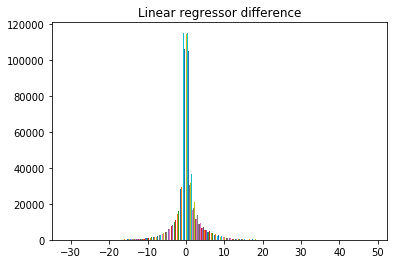

In [91]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [92]:
uif_out.reshape(-1,1).shape

(21430656, 1)

## Average Error Plots

In [93]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

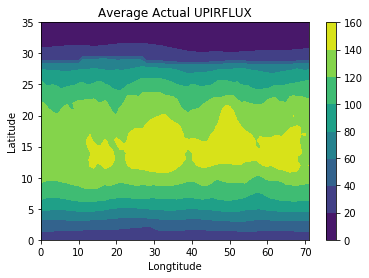

In [94]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

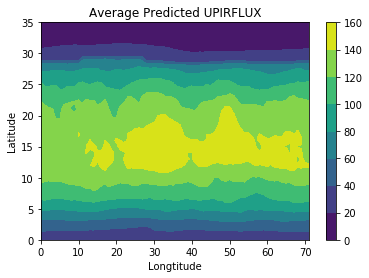

In [95]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

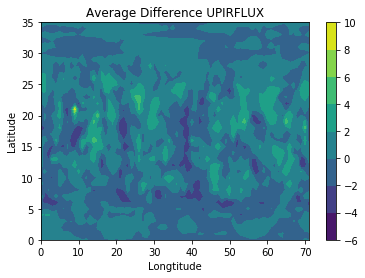

In [96]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

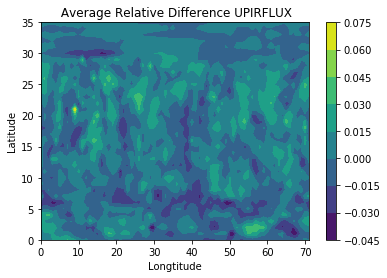

In [97]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [98]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

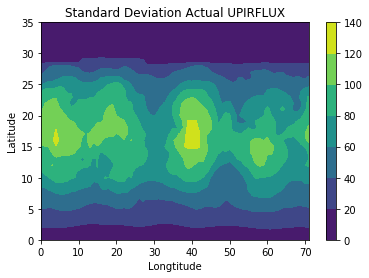

In [99]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

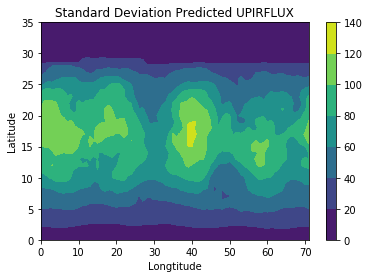

In [100]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

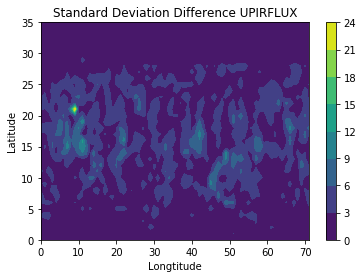

In [101]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [102]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [103]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [104]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.10633973, -0.06554923,  0.34199089, ...,  0.29197278,
         0.32219197,  0.10231304],
       [ 0.10634594, -0.0655502 ,  0.34199473, ...,  0.29197159,
         0.32219859,  0.10230979],
       [ 0.10635081, -0.06555059,  0.34199735, ...,  0.29197081,
         0.32220379,  0.10230736],
       ...,
       [ 0.20920809, -0.18882531,  0.0833361 , ...,  0.54816581,
         0.56314315,  0.10367323],
       [ 0.20446164, -0.18807432,  0.09539458, ...,  0.56183129,
         0.54808466,  0.10490006],
       [ 0.20585376, -0.2075836 ,  0.11684755, ...,  0.58118378,
         0.54497499,  0.08751022]])

In [105]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.54635301, 0.54635925, 0.54636391, 0.54646113, 0.54664196,
       0.54673866, 0.54687026, 0.54656802, 0.5457115 , 0.54504086,
       0.54486358, 0.54487276, 0.54481426, 0.54452895, 0.54390899,
       0.54304769, 0.5420026 , 0.54073744, 0.53974988, 0.53957824,
       0.54016539, 0.54086076, 0.54040744, 0.53707299, 0.53005714,
       0.52253029, 0.51327374, 0.50286578, 0.49314347, 0.48581606,
       0.48235976, 0.48013029, 0.47951019, 0.48135179, 0.48463254,
       0.48566008, 0.4790792 , 0.51365884, 0.53541154, 0.54268907,
       0.55171315, 0.55767999, 0.56307641, 0.56730186, 0.57052055,
       0.57252953, 0.57448064, 0.57685011, 0.58238876, 0.59646956,
       0.62224673, 0.65527373])

In [106]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.15401122, -0.15401764, -0.15402224, -0.15402897, -0.15410321,
       -0.15438783, -0.15436344, -0.15420596, -0.1542604 , -0.15467353,
       -0.15493107, -0.15498071, -0.15534854, -0.15605193, -0.15656802,
       -0.15700791, -0.15776322, -0.15883072, -0.15966822, -0.1597456 ,
       -0.15899286, -0.15824469, -0.15869266, -0.16132947, -0.1664096 ,
       -0.17325125, -0.18070058, -0.18824942, -0.19596226, -0.20385571,
       -0.20909107, -0.21003473, -0.20607251, -0.20005624, -0.20043488,
       -0.20784569, -0.22154738, -0.23695742, -0.25155001, -0.25927781,
       -0.26767585, -0.2725393 , -0.27761698, -0.28339933, -0.2903927 ,
       -0.29457486, -0.29709576, -0.29772588, -0.29501732, -0.28642865,
       -0.27742201, -0.28599483])

In [107]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.18489336, 0.18489517, 0.18489642, 0.18491041, 0.18494964,
       0.18502865, 0.18504844, 0.18501327, 0.18485666, 0.18478373,
       0.18482314, 0.18479526, 0.18476316, 0.18477838, 0.18480097,
       0.18481498, 0.18479759, 0.18473498, 0.18466743, 0.18464701,
       0.18467852, 0.18469141, 0.18460698, 0.18445786, 0.18423655,
       0.18377295, 0.1831007 , 0.18237963, 0.18200797, 0.18234063,
       0.18290527, 0.18285893, 0.18138314, 0.17998441, 0.18139011,
       0.18533912, 0.19093156, 0.19694704, 0.20274813, 0.20605822,
       0.21032224, 0.21310099, 0.21595074, 0.21889133, 0.2218695 ,
       0.22344901, 0.22421481, 0.22396528, 0.22258854, 0.2203381 ,
       0.2206577 , 0.23100682])

In [108]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.18069492, 0.18069775, 0.18070004, 0.18074376, 0.18079092,
       0.1807065 , 0.18063584, 0.18049333, 0.18032189, 0.18016916,
       0.17998416, 0.17981638, 0.17967925, 0.17946817, 0.17910519,
       0.17847365, 0.17752904, 0.17644643, 0.1758107 , 0.17623107,
       0.1777259 , 0.17934998, 0.17951863, 0.17699625, 0.17156327,
       0.16369088, 0.1548515 , 0.14675092, 0.14000858, 0.13452592,
       0.1326348 , 0.13622074, 0.14436898, 0.15392462, 0.15894603,
       0.1589868 , 0.15794567, 0.15991336, 0.16196813, 0.1634072 ,
       0.16563652, 0.1675376 , 0.16965194, 0.17155939, 0.17309183,
       0.17388501, 0.17466826, 0.17597706, 0.17838788, 0.18282102,
       0.18911489, 0.19856161])

In [109]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.1704363331733295


# Last test set:

In [110]:
uif_lin = rfr1.predict(sla_test_set)
uif_out = uif_test_set

In [111]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

9.979841689375421

In [112]:
np.min(uif_out)

16.084946

In [113]:
np.max(uif_out)

489.8716

In [114]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

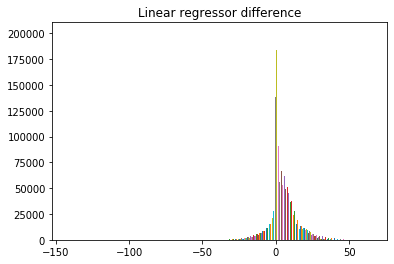

In [115]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [116]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [117]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

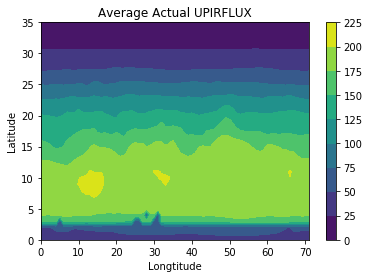

In [118]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

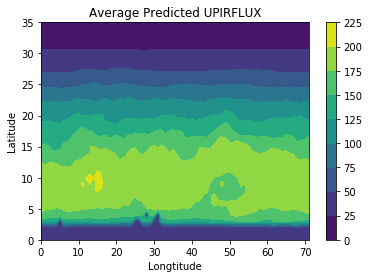

In [119]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

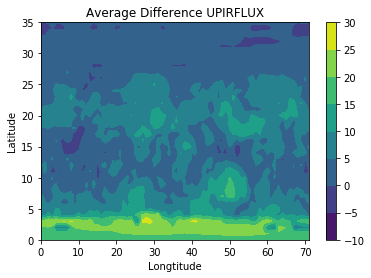

In [120]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

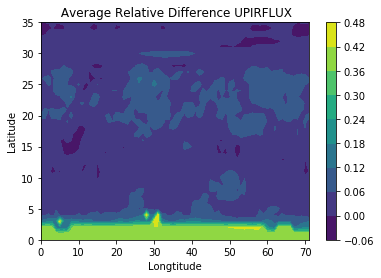

In [121]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [122]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

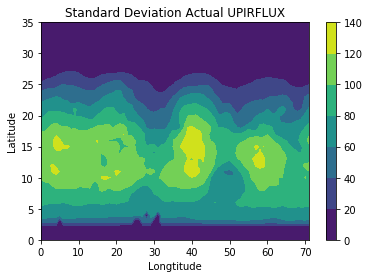

In [123]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

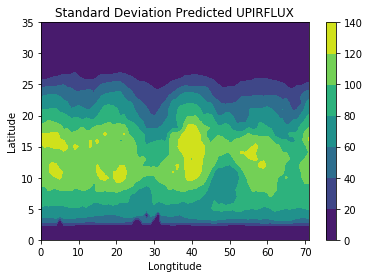

In [124]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

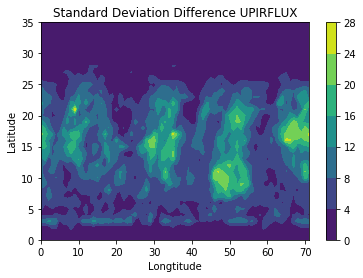

In [125]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [126]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [127]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [128]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[5.06002967, 5.57318242, 5.0458786 , ..., 4.3768093 , 4.86450727,
        5.27820153],
       [5.06004457, 5.57318123, 5.04587529, ..., 4.37677342, 4.86444594,
        5.27816533],
       [5.06005433, 5.5731785 , 5.04587155, ..., 4.37674816, 4.86440153,
        5.27814004],
       ...,
       [7.46627261, 7.12889316, 7.01478423, ..., 6.1261469 , 7.03465122,
        6.60139208],
       [7.36496049, 7.02795934, 6.92800147, ..., 6.04483745, 6.9540959 ,
        6.49133791],
       [7.23607739, 6.8642133 , 6.83287639, ..., 5.93929355, 6.83703404,
        6.31413723]])

In [129]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([5.72318262, 5.72315361, 5.72313061, 5.72285657, 5.72259794,
       5.72310696, 5.72446013, 5.72650162, 5.72881677, 5.73071461,
       5.73218978, 5.73362905, 5.73484685, 5.73680329, 5.74200204,
       5.75204543, 5.76729847, 5.7873977 , 5.80818966, 5.82375736,
       5.83538017, 5.84974968, 5.87360811, 5.91471106, 5.97805347,
       6.06062551, 6.15483988, 6.25528501, 6.3549207 , 6.45290049,
       6.5602896 , 6.67713595, 6.80660893, 6.95636469, 7.13394599,
       7.3432058 , 7.5285771 , 7.70613287, 7.8420908 , 7.87456816,
       7.89621117, 7.90477646, 7.90875311, 7.90606219, 7.89455071,
       7.88047444, 7.85774862, 7.82517975, 7.7825859 , 7.72453506,
       7.639898  , 7.51882757])

In [130]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([4.32194268, 4.32192785, 4.32191754, 4.32185399, 4.32159946,
       4.32104878, 4.32037905, 4.31943793, 4.31915007, 4.31986472,
       4.32197128, 4.32609071, 4.33305045, 4.34390301, 4.35872242,
       4.37406471, 4.3872809 , 4.3992545 , 4.4097654 , 4.42063848,
       4.43432088, 4.45496669, 4.4926159 , 4.55132493, 4.62145357,
       4.69408433, 4.77395129, 4.86744742, 4.96948516, 5.07790412,
       5.20562026, 5.34971754, 5.49190045, 5.63200438, 5.80129124,
       6.04134651, 6.29752702, 6.49265725, 6.55321082, 6.54506698,
       6.5234691 , 6.50414096, 6.47770746, 6.44223159, 6.39701447,
       6.35993066, 6.31625257, 6.26579709, 6.20143994, 6.12226347,
       6.0330192 , 5.92635176])

In [131]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.352906  , 0.35290502, 0.35290376, 0.35289735, 0.35293158,
       0.3531628 , 0.35360414, 0.3541726 , 0.35457977, 0.35464591,
       0.35431207, 0.35351036, 0.35222263, 0.35075119, 0.34978186,
       0.34990122, 0.35082215, 0.35181801, 0.3527648 , 0.35349817,
       0.35332736, 0.35185026, 0.34829414, 0.34355448, 0.34118975,
       0.34296614, 0.34700025, 0.34951046, 0.34965274, 0.3479969 ,
       0.34358027, 0.33623713, 0.33238448, 0.33605801, 0.33961514,
       0.33091349, 0.31664592, 0.31494873, 0.32660833, 0.33405376,
       0.34386856, 0.35123773, 0.36007238, 0.37025439, 0.38129239,
       0.38897544, 0.39602249, 0.40209423, 0.40813364, 0.41331565,
       0.41467305, 0.41460454])

In [132]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([5.0562865 , 5.05627288, 5.05626234, 5.056134  , 5.05597179,
       5.05603023, 5.05648883, 5.05734862, 5.05846669, 5.05978993,
       5.06157008, 5.0643305 , 5.0687557 , 5.0755511 , 5.08485741,
       5.09608984, 5.10890182, 5.12355748, 5.1389092 , 5.15518241,
       5.1735329 , 5.19589351, 5.22792043, 5.27625233, 5.33956417,
       5.4148371 , 5.50420928, 5.60884856, 5.71892764, 5.83070563,
       5.9569243 , 6.09797482, 6.24952504, 6.41945461, 6.61333293,
       6.83710689, 7.04837013, 7.20599625, 7.27956093, 7.28392793,
       7.27416066, 7.26155366, 7.24211145, 7.21499067, 7.17995898,
       7.15101712, 7.11606038, 7.07223072, 7.01576131, 6.94409937,
       6.85195719, 6.72768162])

In [133]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
5.920792420816167
